In [1]:
import qiskit
print("Qiskit:",qiskit.__qiskit_version__)
from qiskit import *
from qiskit.quantum_info import Statevector 
# from qiskit_textbook.tools import array_to_latex
from qiskit.visualization import plot_bloch_multivector, plot_state_qsphere
from qiskit.visualization import plot_histogram

# find the least busy backend 
# provider = IBMQ.get_provider(hub='ibm-q')
from qiskit.providers.ibmq import least_busy
# backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 2 and
#                                    not b.configuration().simulator and b.status().operational==True))
# job_exp = execute(circuit, backend=backend, shots=1024)
from qiskit.tools.monitor import job_monitor
# job_monitor(job_exp)  # displays job status under cell

from IPython.display import clear_output
clear_output()
from qiskit import Aer
from qiskit.circuit.library import QFT
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.quantum_info import state_fidelity
from qiskit.aqua.algorithms import HHL, NumPyLSsolver
from qiskit.aqua.components.eigs import EigsQPE
from qiskit.aqua.components.reciprocals import LookupRotation
from qiskit.aqua.operators import MatrixOperator
from qiskit.aqua.components.initial_states import Custom
import numpy as np
from IPython.display import clear_output
clear_output()
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram
from math import gcd


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).


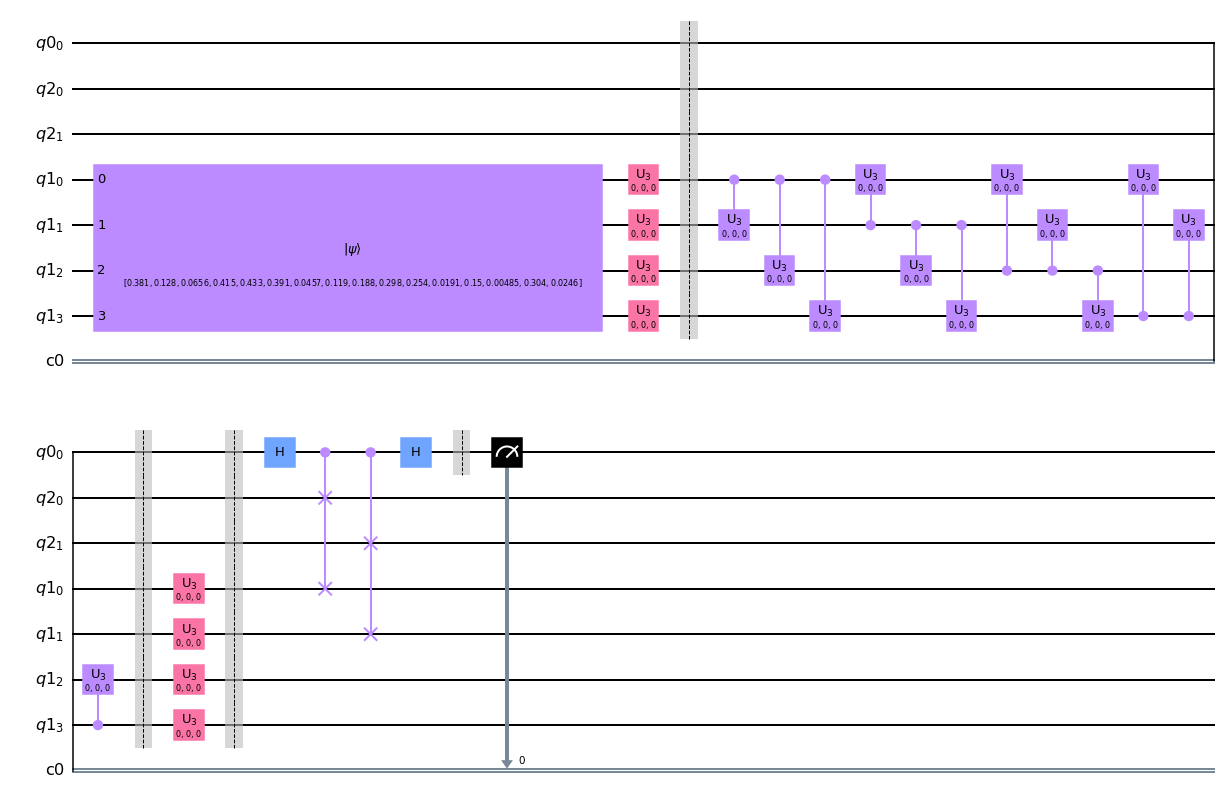

In [2]:
input_dim = 4
reference_dim = 2
### --> latent space dim = n_input - reference_dim
thetas = [0]*(input_dim*(input_dim-1)+2*input_dim)
phis = [0]*(input_dim*(input_dim-1)+2*input_dim)
lambdas = [0]*(input_dim*(input_dim-1)+2*input_dim)

init_state = np.random.rand(2**input_dim)   ###random init state
init_state = init_state/np.linalg.norm(init_state)

def make_circuitB(init_state,input_dim,reference_dim,thetas,phis,lambdas):
  classical_qubit = ClassicalRegister(1)    ### for swap test
  swap_test_qubit = QuantumRegister(1)      ### for swap test
  input = QuantumRegister(input_dim)
  reference_state = QuantumRegister(reference_dim)

  #intializing circuit
  qc = QuantumCircuit(classical_qubit, swap_test_qubit, reference_state, input)
  qc.initialize(init_state,input)

  para_index=0
  for i in range(input_dim):
    qc.u3(thetas[para_index],phis[para_index],lambdas[para_index], input[i])
    para_index+=1
  qc.barrier()
  
  for i in range(0,input_dim):
    for j in range(0,input_dim):
      if j!=i:
        qc.cu3(thetas[para_index],phis[para_index],lambdas[para_index], input[i], input[j])
        para_index+=1
  qc.barrier()  
  for i in range(input_dim):
    qc.u3(thetas[para_index],phis[para_index],lambdas[para_index], input[i])
    para_index+=1
  ###SWAP test for measuring fidelity
  qc.barrier()
  qc.h(swap_test_qubit)
  for i in range(reference_dim):
    qc.cswap(swap_test_qubit,input[i],reference_state[i])
  qc.h(swap_test_qubit)
  qc.snapshot('swap_p', snapshot_type="probabilities",qubits=swap_test_qubit)
  qc.measure(swap_test_qubit,classical_qubit)
  return qc

qc=make_circuitB(init_state,input_dim,reference_dim,thetas,phis,lambdas)

# qc=QuantumCircuit(2)
qc.draw('mpl')

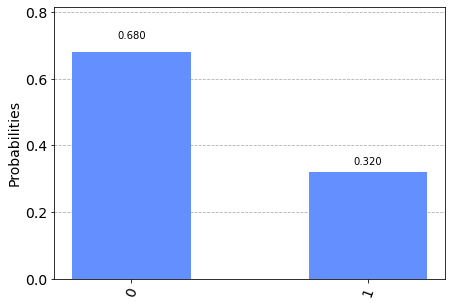

In [3]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=simulator, shots=1000).result().get_counts(qc)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [35]:
from scipy import optimize

def calculate_fidelity(x0,training_inputs):
  x0=np.reshape(x0,(3,-1))
  thetas = x0[0]
  phis = x0[1]
  lambdas = x0[2]
  input_dim = 4
  reference_dim = 2
  total_error = 0
  shots = 1
  for input_sv in training_inputs:
    qc=make_circuitB(input_sv,input_dim,reference_dim,thetas,phis,lambdas)
    res = execute(qc, simulator,shots=shots).result()
    probability = res.data()['snapshots']['probabilities']['swap_p'][0]['value']
    #print(probability)
    #counts =res.get_counts(qc)
    #print(counts['1']/shots )
    #if '0' in counts:
    #    count_0 = counts['0']
    #else:
    #    count_0 = 0
    #fidel = np.sqrt(max(0,2*count_0/shots-1))
    fidel = np.sqrt(max(0,2*probability['0x0']-1))
    #print("f",fidel)
    total_error +=np.log(1-fidel)
  total_error /= training_inputs.shape[0]
  #print("ob:",total_error)
  return total_error
  
  
  

In [39]:
def evolution(input_dim,reference_dim,thetas,phis,lambdas):
  classical_qubit = ClassicalRegister(1)    ### for swap test
  swap_test_qubit = QuantumRegister(1)      ### for swap test
  input = QuantumRegister(input_dim)
  reference_state = QuantumRegister(reference_dim)

  #intializing circuit
  qc = QuantumCircuit(classical_qubit, swap_test_qubit, reference_state, input)

  para_index=0
  for i in range(input_dim):
    qc.u3(thetas[para_index],phis[para_index],lambdas[para_index], input[i])
    para_index+=1
  qc.barrier()
  
  for i in range(0,input_dim):
    for j in range(0,input_dim):
      if j!=i:
        qc.cu3(thetas[para_index],phis[para_index],lambdas[para_index], input[i], input[j])
        para_index+=1
  qc.barrier()  
  for i in range(input_dim):
    qc.u3(thetas[para_index],phis[para_index],lambdas[para_index], input[i])
    para_index+=1
  ###SWAP test for measuring fidelity
  qc.barrier()
  qc.h(swap_test_qubit)
  for i in range(reference_dim):
    qc.cswap(swap_test_qubit,input[i],reference_state[i])
  qc.h(swap_test_qubit)
  # qc.measure(swap_test_qubit,classical_qubit)
  return qc 

def get_init_state(init_sv):
  '''tensor product input with aiding qubits (reference state & swap_test_qubit)
  '''
  state=[]
  for i in range(2**(input_dim+reference_dim+1)):
    if i%(2**(reference_dim+1))==0:
      state.append(init_sv[i//2**(reference_dim+1)])
    else:
      state.append(0)
  state=Statevector(state)
  return state


def calculate_fidelity(x0,training_inputs):
  x0=np.reshape(x0,(3,-1))
  thetas = x0[0]
  phis = x0[1]
  lambdas = x0[2]
  total_error = 0
  U=evolution(input_dim,reference_dim,thetas,phis,lambdas)
  for input_sv in training_inputs:
    state=get_init_state(input_sv)
    final_state=state.evolve(U)     ###evolution
    ##tracing over all except the swap_test_qubit
    p_0=qiskit.quantum_info.partial_trace(final_state,range(1,input_dim+reference_dim+1)).probabilities()[0]  
    fidel=np.sqrt(max(0,2*p_0-1))
    total_error +=np.log(1-fidel)
  total_error /= training_inputs.shape[0]
  #print("\b obj:",total_error)
  return total_error

In [5]:
import numpy as np
n_para = (input_dim*(input_dim-1)+2*input_dim)*3
dim_state = 2**input_dim
n_state = 10
x0 = np.random.uniform(np.pi,np.pi*3,n_para)
test_states = np.random.uniform(-1,1,dim_state*n_state)+np.random.uniform(-1,1,dim_state*n_state)*1j
test_states = test_states.reshape((n_state,dim_state))
for i in range(dim_state):
    if i% 4 !=0:
        test_states[:,i]=0
        
for i in range(n_state):
    test_states[i] = test_states[i] / np.linalg.norm(test_states[i])
    
minimizer_kwargs ={
    "method" : "L-BFGS-B",
    "args"   : test_states,
    "bounds" : optimize.Bounds(0,4*np.pi),
    "options": {"iprint" : 100, "maxls": 15, "disp": True}
}


In [29]:
# Create molecule test data sets
from qiskit.chemistry.drivers import PyQuanteDriver, UnitsType, Molecule, BasisType
from qiskit.chemistry.transformations import FermionicTransformation, FermionicQubitMappingType, FermionicTransformationType
from qiskit.chemistry.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np

#transformation = FermionicTransformation(qubit_mapping=FermionicQubitMappingType.JORDAN_WIGNER)
transformation = FermionicTransformation(
            transformation=FermionicTransformationType.FULL,
            qubit_mapping=FermionicQubitMappingType.PARITY,
            two_qubit_reduction=True,
            freeze_core=False)

from qiskit.aqua.algorithms import NumPyMinimumEigensolver
numpy_solver = NumPyMinimumEigensolver()


n_distance=12
n_angle = 4
a_constants = np.linspace(0.2,2,n_distance)**2
angles = np.linspace(0,2.5,n_angle)
a_mg,angle_mg = np.meshgrid(a_constants,angles)
a_mg = a_mg.flatten()
angle_mg = angle_mg.flatten()
n_sample=n_angle*n_distance

state_vector = np.zeros((n_sample,dim_state),dtype=np.complex128)
state_energy = np.zeros((n_sample))

for i in range(n_sample):
    molecule = Molecule(geometry=[['H', [0., 0., 0.]],
                                  ['H', [0., 0., a_mg[i]]],
                                  ['H', [0., np.sin(angle_mg[i])*a_mg[i], -np.cos(angle_mg[i])*a_mg[i]]],
                                  ],
                     charge=-1, multiplicity=1)
    
    driver = PyQuanteDriver(molecule = molecule, units=UnitsType.ANGSTROM, basis=BasisType.BSTO3G)
    qubit_op, _ = transformation_2.transform(driver)
    calc = GroundStateEigensolver(transformation, numpy_solver)
    res = calc.solve(driver)
    state_energy[i]=res.groundenergy
    state_vector[i]=res.groundstate.to_matrix()
    

#%plot(state_energy)

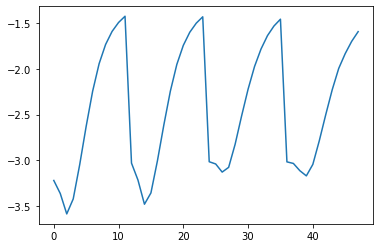

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(state_energy)
minimizer_kwargs ={
    "method" : "L-BFGS-B",
    "args"   : state_vector,
    "bounds" : optimize.Bounds(0,4*np.pi),
    "options": {"iprint" : 100, "maxls": 15, "disp": True}
}

In [ ]:
calculate_fidelity(x0,test_states)

In [ ]:
local_mins =[]

def record_local_mins(x,f,accept):
    local_mins.append((x,f))
    print("x:")
    print(x)
ret = optimize.basinhopping(calculate_fidelity, x0, minimizer_kwargs=minimizer_kwargs,
                   niter=200,disp=True,niter_success=10,callback=record_local_mins)

In [ ]:
from threadpoolctl import threadpool_info
import numpy as np
from pprint import pprint
pprint(threadpool_info())